In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
import numpy as np
np.random.seed(0)
import itertools
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                         image_size=(256, 256))
test_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                        image_size=(256, 256))

rescale = Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
test_gen  = test_gen.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [3]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(256, 256, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.MaxPooling2D(3, 3))

model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.MaxPooling2D(3, 3))

model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.MaxPooling2D(3, 3))

model.add(keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same"))

model.add(keras.layers.Conv2D(512, (5, 5), activation="relu", padding="same"))
model.add(keras.layers.Conv2D(512, (5, 5), activation="relu", padding="same"))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1568, activation="relu"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(38, activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the model
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',  # You can choose the metric to monitor, e.g., validation accuracy
    mode='max',
    save_best_only=True
)

# Train the model with the ModelCheckpoint callback
history = model.fit(train_gen, epochs=10, validation_data=test_gen , callbacks=[model_checkpoint_callback])

# Now, your model will be saved in the specified file when the validation accuracy is maximized.


Epoch 1/10
2197/2197 [==============================] - 358s 156ms/step - loss: 1.6127 - accuracy: 0.5315 - val_loss: 0.5789 - val_accuracy: 0.8190
Epoch 2/10
2197/2197 [==============================] - 336s 153ms/step - loss: 0.4318 - accuracy: 0.8608 - val_loss: 0.2868 - val_accuracy: 0.9054
Epoch 3/10
2197/2197 [==============================] - 336s 153ms/step - loss: 0.2585 - accuracy: 0.9148 - val_loss: 0.2302 - val_accuracy: 0.9277
Epoch 4/10
2197/2197 [==============================] - 335s 153ms/step - loss: 0.1765 - accuracy: 0.9416 - val_loss: 0.1774 - val_accuracy: 0.9416
Epoch 5/10
2197/2197 [==============================] - 335s 152ms/step - loss: 0.1370 - accuracy: 0.9539 - val_loss: 0.1845 - val_accuracy: 0.9435
Epoch 6/10
2197/2197 [==============================] - 333s 152ms/step - loss: 0.1046 - accuracy: 0.9646 - val_loss: 0.1837 - val_accuracy: 0.9433
Epoch 7/10
2197/2197 [==============================] - 335s 153ms/step - loss: 0.0844 - accuracy: 0.9719 - val_

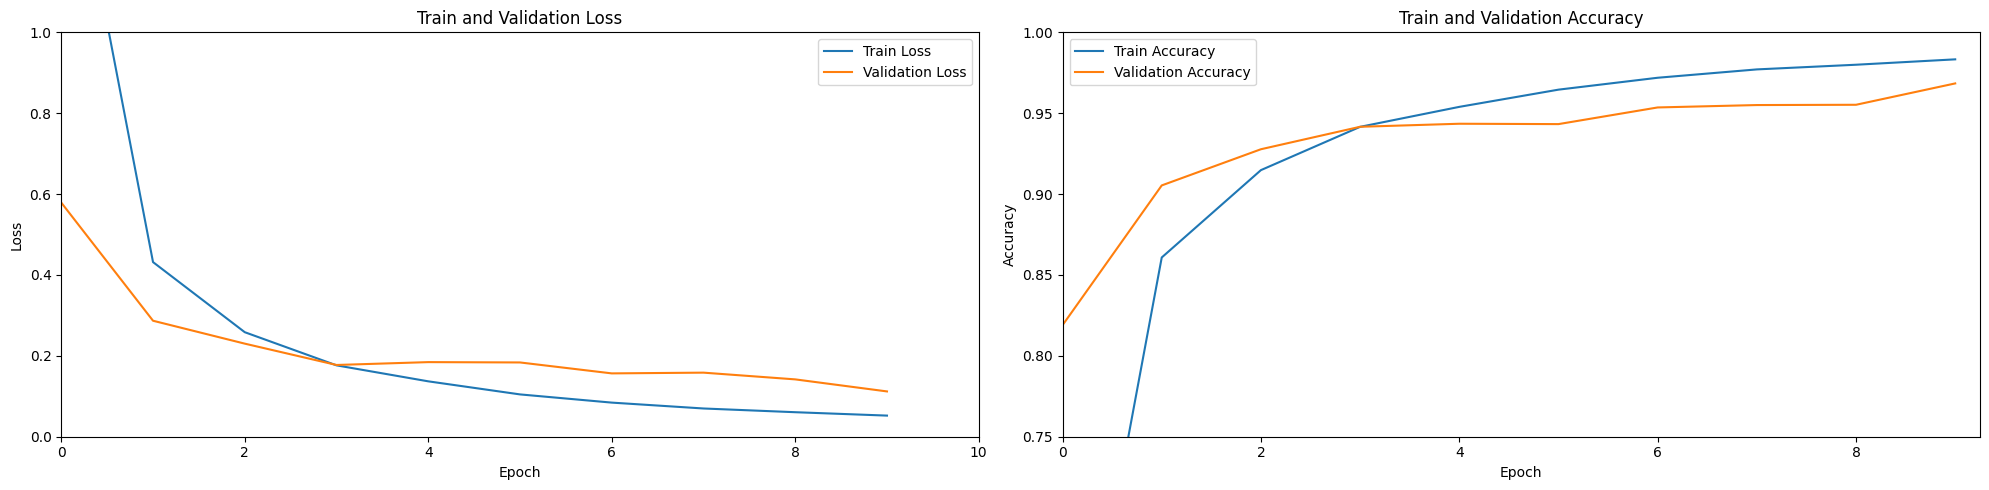

In [4]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [5]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 0s 125ms/step


In [6]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [7]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 98.33 %
Test Accuracy   : 96.84 %
Precision Score : 96.84 %
Recall Score    : 96.84 %


<Figure size 2000x500 with 0 Axes>

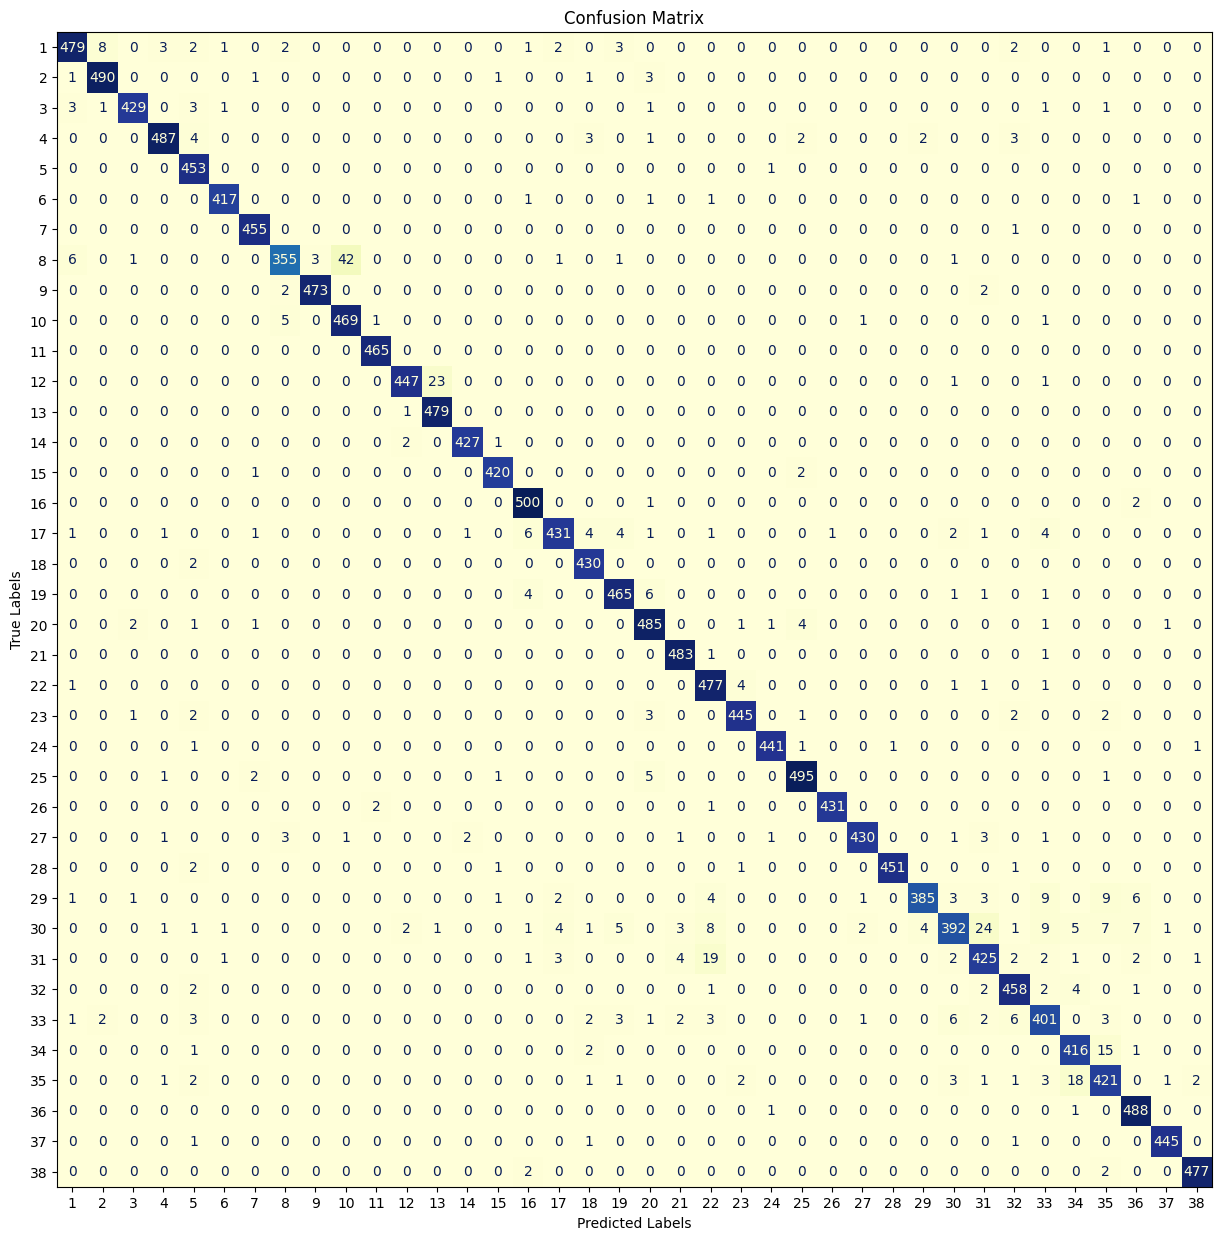

In [8]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()